In [1]:
# Dependencies and Setup
%matplotlib notebook
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as st
import datetime

In [2]:
#Read weekly housing data from Redfin
#Google Drive for reference: 
redfinfile = "weekly_housing_market_data_most_recent.tsv"
housing_redfin_all = pd.read_csv(redfinfile,delimiter = '\t')
housing_redfin_all

,region_id,region_type_id,region_name,region_type,period_begin,period_end,duration,total_homes_sold,total_homes_sold_yoy,average_homes_sold,...,median_days_on_market_yoy,pending_sales_to_sales_ratio,pending_sales_to_sales_ratio_yoy,months_of_supply,months_of_supply_yoy,average_pending_sales_listing_updates,average_pending_sales_listing_updates_yoy,percent_total_price_drops_of_inventory,percent_total_price_drops_of_inventory_yoy,last_updated
0,1885,5,"Grafton County, NH",county,2020-01-20,2020-01-26,1 weeks,13.0,1.166667,13.0,...,-29.5,0.538462,-0.461538,40.076923,-63.923077,37.0,0.088235,0.018000,0.004644,2021-01-20 14:55:38
1,757,5,"Kankakee County, IL",county,2019-05-06,2019-05-12,1 weeks,25.0,0.136364,25.0,...,-53.5,0.680000,0.361818,14.720000,-2.689091,35.0,0.346154,0.048851,-0.019084,2021-01-20 14:55:38
2,757,5,"Kankakee County, IL",county,2020-10-19,2020-10-25,1 weeks,21.0,-0.160000,21.0,...,-19.0,1.380952,0.940952,12.619048,-3.500952,41.0,0.782609,0.052174,0.002436,2021-01-20 14:55:38
3,33340,-2,"Milwaukee, WI metro area",metro,2017-08-28,2017-09-03,1 weeks,650.0,0.074380,650.0,...,-8.0,0.596923,0.046510,11.441538,-1.927057,605.0,2.055556,0.041734,0.005552,2021-01-20 14:55:38
4,819,5,"Boone County, IN",county,2019-01-07,2019-01-13,1 weeks,15.0,0.500000,15.0,...,8.5,0.533333,-0.366667,16.600000,-9.000000,16.0,-0.200000,0.061674,0.015064,2021-01-20 14:55:38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996150,1124,5,"Bullitt County, KY",county,2017-12-25,2018-03-18,12 weeks,218.0,-0.018018,18.0,...,6.8,0.812189,-0.184020,14.814671,-1.625127,31.0,-0.060606,0.219828,-0.060172,2021-01-20 14:55:38
996151,1895,5,"Cape May County, NJ",county,2017-08-21,2017-11-12,12 weeks,934.0,-0.018908,77.0,...,-31.8,0.494829,0.078504,30.696681,-5.052415,85.0,-0.011628,0.381168,0.012277,2021-01-20 14:55:38
996152,867,5,"Montgomery County, IN",county,2018-01-15,2018-04-08,12 weeks,82.0,-0.068182,6.0,...,-17.2,1.033333,0.096176,19.466071,-6.454431,12.0,-0.142857,0.339623,-0.123064,2021-01-20 14:55:38
996153,495,5,"Seminole County, FL",county,2018-07-09,2018-09-30,12 weeks,2151.0,0.075500,179.0,...,0.1,0.749268,-0.001147,11.454032,-1.085844,197.0,0.076503,1.029526,0.192893,2021-01-20 14:55:38


In [3]:
#Only selecting the period_begin starting from 2020-1-1
housing_redfin_all["period_begin"]=pd.to_datetime(housing_redfin_all["period_begin"])

#Keeping the data starting from 2020-1-1
housing_redfin = housing_redfin_all[(housing_redfin_all["period_end"]>'2019-12-31') & (housing_redfin_all["period_end"]<'2021-01-03')]

#reset index
housing_redfin = housing_redfin.reset_index()
housing_redfin

#Look for duration that matches 4 week
housing_redfin = housing_redfin.loc[housing_redfin['duration']=="4 weeks"]

In [4]:
#To see all columns so that we can decide which ones to keep
#list(housing_redfin.columns)

In [5]:
#Convert "period_end" to datetime type
housing_redfin["period_end"] = pd.to_datetime(housing_redfin.loc[:,"period_end"], format='%Y-%m-%d')

In [6]:
#Check the types to see if the datetime conversion is succressful
#housing_redfin.dtypes

In [7]:
#Add a new column "week" with the week number so that the housing data can be merged with COVID data.
housing_redfin["month"] = housing_redfin["period_end"].dt.month

In [8]:
#Extract only the column we need
#For the timeframe, we know we're looking at the per week data, and we only keep the "period_end" so that it aligns with the COVID data.
redfin_clean = housing_redfin[["region_name","month","total_homes_sold","total_homes_sold_with_price_drops","price_drops","total_new_listings"]]
redfin_clean

,region_name,month,total_homes_sold,total_homes_sold_with_price_drops,price_drops,total_new_listings
20364,"Warren, MI metro area",10,4241.0,973.0,406.0,4004.0
20365,"Cheshire County, NH",6,92.0,15.0,6.0,99.0
20366,"Kahului, HI metro area",3,244.0,54.0,30.0,256.0
20611,"Cheshire County, NH",11,90.0,16.0,3.0,57.0
20612,"Warren, MI metro area",8,4421.0,989.0,430.0,4758.0
...,...,...,...,...,...,...
239931,"Saginaw County, MI",1,108.0,39.0,17.0,128.0
239932,"Seminole County, FL",5,522.0,142.0,82.0,677.0
239933,"Polk County, WI",3,36.0,14.0,5.0,68.0
239934,"Crow Wing County, MN",9,169.0,50.0,16.0,217.0


In [9]:
#Selecting California data
redfin_clean = redfin_clean[housing_redfin["region_name"].str.contains('CA')]
redfin_clean

,region_name,month,total_homes_sold,total_homes_sold_with_price_drops,price_drops,total_new_listings
21062,"Los Angeles, CA metro area",7,4587.0,887.0,422.0,7026.0
21810,"Los Angeles, CA metro area",4,4265.0,678.0,274.0,4213.0
21811,"Los Angeles, CA metro area",7,5158.0,997.0,436.0,7411.0
25250,"Los Angeles, CA metro area",4,4607.0,778.0,293.0,4972.0
25258,"Los Angeles, CA metro area",9,6206.0,1083.0,465.0,7779.0
...,...,...,...,...,...,...
232823,"Orange County, CA",4,2155.0,432.0,178.0,2288.0
232830,"Riverside, CA metro area",5,3059.0,751.0,386.0,4484.0
232841,"Riverside, CA metro area",8,5509.0,1242.0,264.0,5607.0
232842,"Orange County, CA",8,2730.0,721.0,271.0,3331.0


In [10]:
#Group by month and see the total of 'total_homes_sold','total_homes_sold_with_price_drop','price_drops','total_new_listings'
redfin_clean = redfin_clean.groupby(['month']).sum()
redfin_clean

,total_homes_sold,total_homes_sold_with_price_drops,price_drops,total_new_listings
month,,,,
1,165653.0,56452.0,12244.0,142548.0
2,154954.0,47253.0,15832.0,232849.0
3,238862.0,57246.0,20467.0,327592.0
4,173421.0,34413.0,14238.0,179891.0
5,172337.0,34360.0,21966.0,265374.0
6,169761.0,40059.0,19904.0,257518.0
7,227056.0,53727.0,19075.0,271192.0
8,325659.0,71685.0,23542.0,366472.0
9,263108.0,52264.0,18441.0,298102.0


In [11]:
#Read Covid data
covid_data = pd.read_csv("United_States_COVID-19_Cases_and_Deaths_by_State_over_Time.csv")
covid_data.head()

,submission_date,state,tot_cases,conf_cases,prob_cases,new_case,pnew_case,tot_death,conf_death,prob_death,new_death,pnew_death,created_at,consent_cases,consent_deaths
0,05/04/2020,KY,5245,5245.0,0.0,115,0.0,261,261.0,0.0,8,0.0,05/05/2020 05:25:08 PM,Agree,Agree
1,12/08/2020,OK,205999,171497.0,34502.0,0,0.0,1752,1680.0,72.0,0,0.0,12/09/2020 02:45:40 PM,Agree,Agree
2,08/21/2020,MD,103523,NaN,NaN,624,0.0,3685,3546.0,139.0,11,1.0,08/22/2020 02:21:09 PM,NaN,Agree
3,03/05/2020,GA,2,NaN,NaN,-5,NaN,0,NaN,NaN,0,NaN,03/26/2020 04:22:39 PM,Agree,Agree
4,02/08/2020,WA,1,NaN,NaN,0,NaN,0,NaN,NaN,0,NaN,03/26/2020 04:22:39 PM,NaN,NaN


In [12]:
#Convert "submission_date" into datetime type
covid_data["submission_date"] = pd.to_datetime(covid_data.loc[:,"submission_date"], format='%m/%d/%Y')
covid_data["month"] = covid_data["submission_date"].dt.month

In [13]:
#Keeping the data starting from 2020-1-1
covid_data = covid_data[(covid_data["submission_date"]>'01/01/2020') & (covid_data["submission_date"]<'01/01/2021')]

In [14]:
#Only selecting "CA" state
covid_data = covid_data[covid_data["state"].str.contains('CA')]

In [15]:
#Extract only the data we need and store it into "clean_covid"
covid_clean = covid_data[["month","new_case","new_death"]]

In [16]:
#Cleaning NaN values 
#Replace NaN with 0 because we are only looking at "newcase"
covid_clean = covid_clean.fillna(0)

In [17]:
#Group by month and see the total of 'new_case' and 'new_death'
covid_clean = covid_clean.groupby(["month"]).sum()
covid_clean

,new_case,new_death
month,,
1,3,0
2,9,0
3,8119,172
4,40786,1810
5,61666,2231
6,112334,1767
7,270671,3025
8,210497,3928
9,106540,2859


In [18]:
#Merge two dataframes on "month"
merged_data = pd.merge(redfin_clean, covid_clean, on='month')
merged_data

,total_homes_sold,total_homes_sold_with_price_drops,price_drops,total_new_listings,new_case,new_death
month,,,,,,
1,165653.0,56452.0,12244.0,142548.0,3,0
2,154954.0,47253.0,15832.0,232849.0,9,0
3,238862.0,57246.0,20467.0,327592.0,8119,172
4,173421.0,34413.0,14238.0,179891.0,40786,1810
5,172337.0,34360.0,21966.0,265374.0,61666,2231
6,169761.0,40059.0,19904.0,257518.0,112334,1767
7,227056.0,53727.0,19075.0,271192.0,270671,3025
8,325659.0,71685.0,23542.0,366472.0,210497,3928
9,263108.0,52264.0,18441.0,298102.0,106540,2859


In [19]:
#Reset index
merged_data.reset_index(level=0, inplace=True)
merged_data

,month,total_homes_sold,total_homes_sold_with_price_drops,price_drops,total_new_listings,new_case,new_death
0,1,165653.0,56452.0,12244.0,142548.0,3,0
1,2,154954.0,47253.0,15832.0,232849.0,9,0
2,3,238862.0,57246.0,20467.0,327592.0,8119,172
3,4,173421.0,34413.0,14238.0,179891.0,40786,1810
4,5,172337.0,34360.0,21966.0,265374.0,61666,2231
5,6,169761.0,40059.0,19904.0,257518.0,112334,1767
6,7,227056.0,53727.0,19075.0,271192.0,270671,3025
7,8,325659.0,71685.0,23542.0,366472.0,210497,3928
8,9,263108.0,52264.0,18441.0,298102.0,106540,2859
9,10,267960.0,48853.0,19808.0,297866.0,111380,1834


<IPython.core.display.Javascript object>


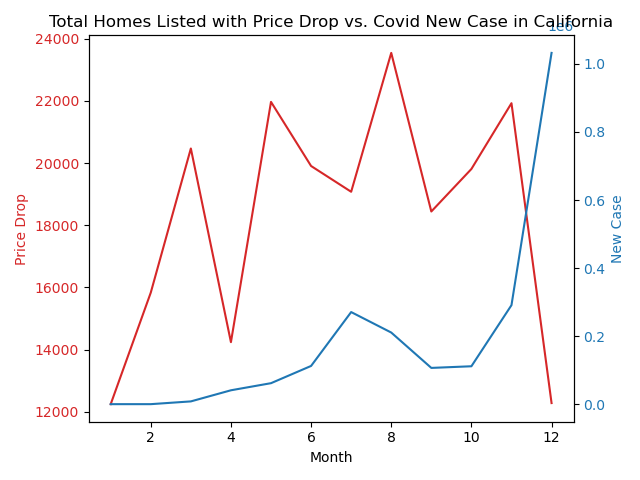

In [22]:
#Question 1: What is the correlation between 
#Case number and Number of homes listed with price drop 
#Based on months?
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Month')
ax1.set_ylabel('Price Drop', color=color)
ax1.plot(merged_data['month'], merged_data['price_drops'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('New Case', color=color)  # we already handled the x-label with ax1
ax2.plot(merged_data['month'], merged_data['new_case'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Total Homes Listed with Price Drop vs. Covid New Case in California')
plt.legend

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

plt.savefig('price_drop.png')

<IPython.core.display.Javascript object>


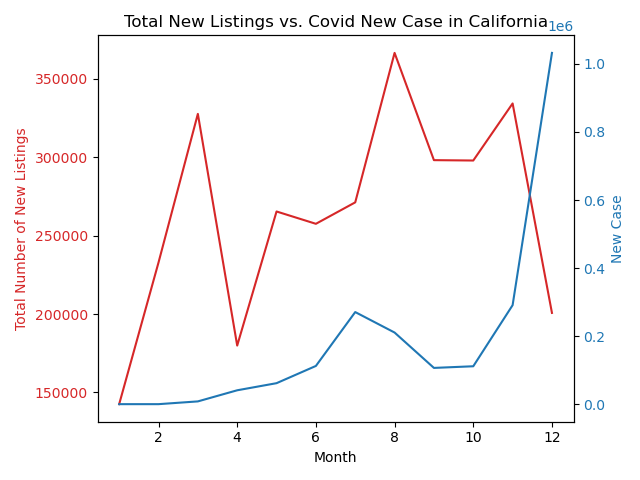

In [31]:
#Question 2: What is the correlation between 
#Case number and Number of new listings
#Based on months?
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Month')
ax1.set_ylabel('Total Number of New Listings', color=color)
ax1.plot(merged_data['month'], merged_data['total_new_listings'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('New Case', color=color)  # we already handled the x-label with ax1
ax2.plot(merged_data['month'], merged_data['new_case'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Total New Listings vs. Covid New Case in California')
plt.legend

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

plt.savefig('NewListing.png')

<IPython.core.display.Javascript object>


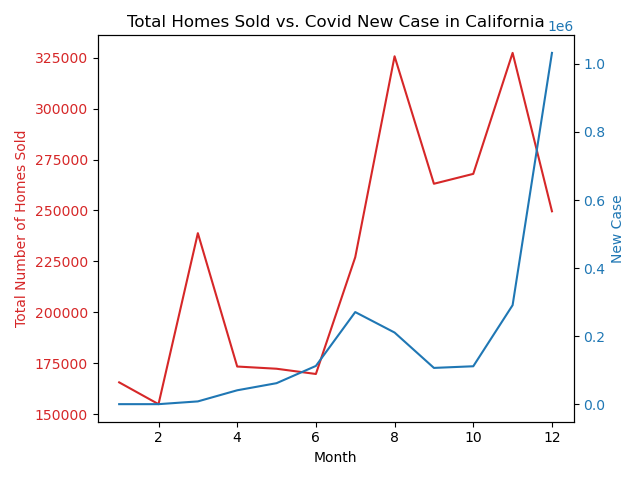

In [24]:
#Question 3: What is the correlation between 
#Case number and Total Homes Sold
#Based on months?
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Month')
ax1.set_ylabel('Total Number of Homes Sold', color=color)
ax1.plot(merged_data['month'], merged_data['total_homes_sold'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('New Case', color=color)  # we already handled the x-label with ax1
ax2.plot(merged_data['month'], merged_data['new_case'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Total Homes Sold vs. Covid New Case in California')
plt.legend

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

plt.savefig('images/total_sold.png')

<IPython.core.display.Javascript object>


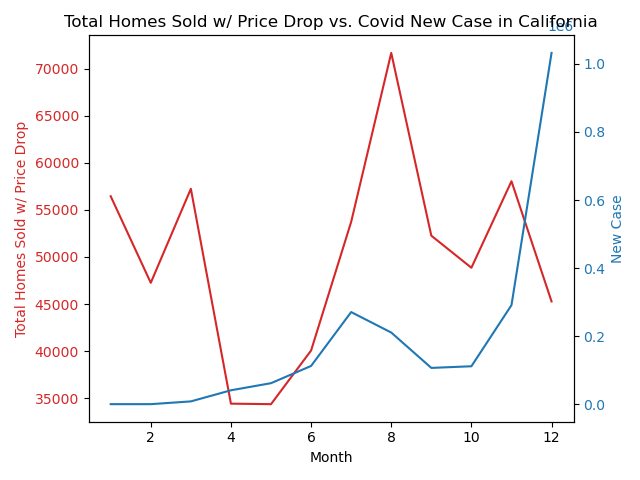

In [25]:
#Question 4: What is the correlation between 
#Case number and Total Homes Sold with Price Drops
#Based on months?
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Month')
ax1.set_ylabel('Total Homes Sold w/ Price Drop', color=color)
ax1.plot(merged_data['month'], merged_data['total_homes_sold_with_price_drops'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('New Case', color=color)  # we already handled the x-label with ax1
ax2.plot(merged_data['month'], merged_data['new_case'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Total Homes Sold w/ Price Drop vs. Covid New Case in California')
plt.legend

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

plt.savefig('price_drop_sold.png')